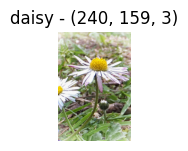

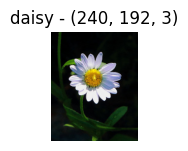

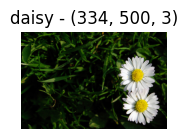

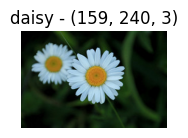

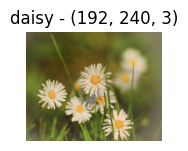

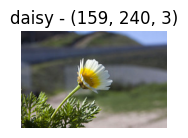

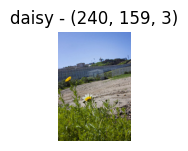

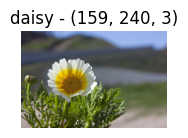

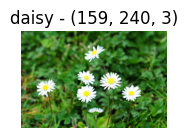

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread

train_dir = './Fleurs/train'
val_dir = './Fleurs/test'

for i in range(9):
    plt.subplot(3, 3, i + 1)
    images = tf.io.gfile.listdir(train_dir + '/' + 'daisy')
    image = imread(train_dir + '/' + 'daisy' + '/' + images[i])
    plt.imshow(image)
    plt.title('daisy' + ' - ' + str(image.shape))
    plt.axis('off')
    plt.show()

In [2]:
# On prend celui qui a le moins d'images pour équilibrer les classes
fleurs = dict()
for fleur in tf.io.gfile.listdir(train_dir):
    fleurs[fleur] = len(tf.io.gfile.listdir(train_dir + '/' + fleur))
print(fleurs)   
print(min(fleurs.values()))

{'daisy': 412, 'dandelion': 412, 'rose': 412, 'sunflower': 412, 'tulip': 412}
412


In [3]:
# Chaque classe doit avoir le même nombre d'images, on va donc supprimer les images en trop
min_images = min(fleurs.values())

for fleur in tf.io.gfile.listdir(train_dir):
    images = tf.io.gfile.listdir(train_dir + '/' + fleur)
    for image in images[min_images:]:
        tf.io.gfile.remove(train_dir + '/' + fleur + '/' + image)
        print(len(tf.io.gfile.listdir(train_dir + '/' + fleur)))

In [4]:
# On va mettre la moitié des images de chaque classe dans le dossier test
if len(tf.io.gfile.listdir(val_dir)) == 0:
    tf.io.gfile.rmtree(val_dir)
    tf.io.gfile.makedirs(val_dir)
    
#     for fleur in tf.io.gfile.listdir(train_dir):
#         i = len(tf.io.gfile.listdir(train_dir + '/' + fleur))
#         tf.io.gfile.makedirs(val_dir + '/' + fleur)
#         images = tf.io.gfile.listdir(train_dir + '/' + fleur)
#         y = 0
#         for image in images:
#             if y <= i/1.2:
#                 tf.io.gfile.copy(train_dir + '/' + fleur + '/' + image, val_dir + '/' + fleur + '/' + image)
#                 tf.io.gfile.remove(train_dir + '/' + fleur + '/' + image)
#                 y+= 1

# Supposons que val_dir est le dossier test et train_dir est le dossier d'entraînement
    for fleur in tf.io.gfile.listdir(train_dir):
        images = tf.io.gfile.listdir(train_dir + '/' + fleur)
        total_images = len(images)
        test_images = images[:400]  # Premières 400 images pour le test
        train_images = images[400:909]  # Suivantes 509 images pour l'entraînement

        # Assurez-vous que le dossier existe pour chaque classe dans l'ensemble de test
        tf.io.gfile.makedirs(val_dir + '/' + fleur)

        # Déplacer les images dans le dossier de test approprié
        for image in test_images:
            tf.io.gfile.copy(train_dir + '/' + fleur + '/' + image, val_dir + '/' + fleur + '/' + image)
            tf.io.gfile.remove(train_dir + '/' + fleur + '/' + image)


In [5]:
# On vérifie que tout est bon
len(tf.io.gfile.listdir(train_dir))

print("Sur le dossier train :")

for fleur in tf.io.gfile.listdir(train_dir):
    print(f"{fleur} - {len(tf.io.gfile.listdir(train_dir + '/' + fleur))} images")
    
print("\nSur le dossier test :")

for fleur in tf.io.gfile.listdir(val_dir):
    print(f"{fleur} - {len(tf.io.gfile.listdir(val_dir + '/' + fleur))} images")

Sur le dossier train :
daisy - 412 images
dandelion - 412 images
rose - 412 images
sunflower - 412 images
tulip - 412 images

Sur le dossier test :
daisy - 400 images
dandelion - 400 images
rose - 400 images
sunflower - 400 images
tulip - 400 images


In [6]:
# On enregistre les images dans des générateurs
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    seed = 42
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    seed = 42
)

Found 2060 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [7]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)


model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        1849

In [8]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

history = model.fit(train_gen, epochs=20, validation_data=val_gen)


Epoch 1/20


103/103 [==============================] - 9s 80ms/step - loss: 1.2698 - accuracy: 0.4617 - val_loss: 1.1703 - val_accuracy: 0.5140
Epoch 2/20
103/103 [==============================] - 8s 77ms/step - loss: 1.0321 - accuracy: 0.5840 - val_loss: 1.0789 - val_accuracy: 0.5655
Epoch 3/20
103/103 [==============================] - 8s 79ms/step - loss: 0.8623 - accuracy: 0.6738 - val_loss: 1.0795 - val_accuracy: 0.5700
Epoch 4/20
103/103 [==============================] - 9s 85ms/step - loss: 0.7051 - accuracy: 0.7354 - val_loss: 1.0951 - val_accuracy: 0.5850
Epoch 5/20
103/103 [==============================] - 9s 83ms/step - loss: 0.5150 - accuracy: 0.8121 - val_loss: 1.1523 - val_accuracy: 0.5905
Epoch 6/20
103/103 [==============================] - 8s 79ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 1.3133 - val_accuracy: 0.6015
Epoch 7/20
103/103 [==============================] - 8s 79ms/step - loss: 0.1791 - accuracy: 0.9417 - val_loss: 1.5830 - val_accuracy: 0.5

In [9]:
def diagnostic_learning_curves():
  # Retrieve a list of accuracy results on training and validation data
  # sets for each training epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  # Retrieve a list of list results on training and validation data
  # sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get number of epochs
  epochs = range(len(acc))

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, acc)
  plt.plot(epochs, val_acc)
  plt.title('Training and validation accuracy')

  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  plt.title('Training and validation loss')

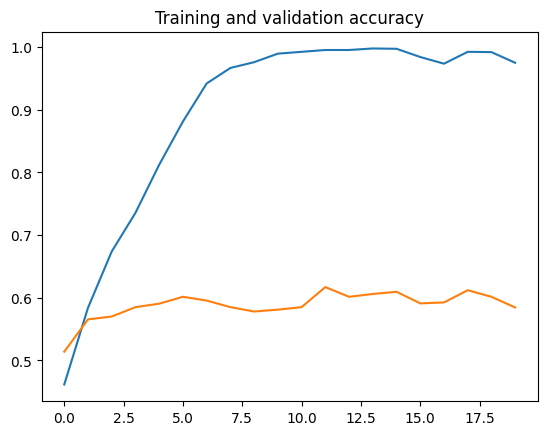

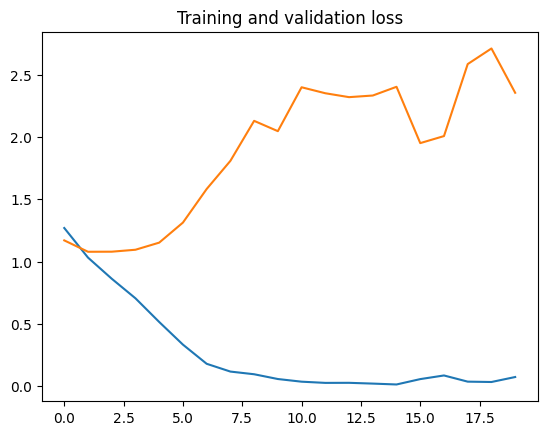

In [10]:
diagnostic_learning_curves()

In [11]:
prediction = model.predict(val_gen)
print(f"Prediction shape: {prediction.shape}")

100/100 [==============================] - 4s 34ms/step
Prediction shape: (2000, 5)


In [12]:
model.evaluate(val_gen)

100/100 [==============================] - 3s 34ms/step - loss: 2.3559 - accuracy: 0.5845


[2.3559012413024902, 0.5845000147819519]

In [13]:
y_pred = (prediction > 0.5).astype('int32')

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [15]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 2060 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [16]:

import tensorflow as tf

# Définition de l'architecture du modèle avec des couches de Dropout pour réduire le surajustement
inputs = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.25)(x)  # couche de Dropout

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.25)(x)  # couche de Dropout

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.25)(x)  # couche de Dropout

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Ajout de la régularisation L2
x = tf.keras.layers.Dropout(0.5)(x)  # Augmenter le taux de dropout pour la couche dense

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compilation du modèle avec un taux d'apprentissage ajusté
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Ajustez le taux d'apprentissage si nécessaire
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                      

x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Ajout de la régularisation L2

L'effet de cette régularisation sera de légèrement augmenter la fonction de perte lorsque les poids de la couche augmentent, poussant le modèle à rechercher des configurations de poids qui réalisent un bon équilibre entre l'ajustement aux données et la simplicité du modèle.


In [17]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

history = model.fit(train_gen, epochs=75, validation_data=val_gen,verbose=2)

Epoch 1/75
103/103 - 10s - loss: 2.4057 - accuracy: 0.3029 - val_loss: 1.6507 - val_accuracy: 0.4070 - 10s/epoch - 99ms/step
Epoch 2/75
103/103 - 9s - loss: 1.4920 - accuracy: 0.4471 - val_loss: 1.4352 - val_accuracy: 0.4435 - 9s/epoch - 87ms/step
Epoch 3/75
103/103 - 9s - loss: 1.3547 - accuracy: 0.4893 - val_loss: 1.3634 - val_accuracy: 0.4720 - 9s/epoch - 86ms/step
Epoch 4/75
103/103 - 9s - loss: 1.2858 - accuracy: 0.5277 - val_loss: 1.3326 - val_accuracy: 0.5155 - 9s/epoch - 86ms/step
Epoch 5/75
103/103 - 9s - loss: 1.2160 - accuracy: 0.5223 - val_loss: 1.2732 - val_accuracy: 0.5220 - 9s/epoch - 85ms/step
Epoch 6/75
103/103 - 9s - loss: 1.2158 - accuracy: 0.5466 - val_loss: 1.2365 - val_accuracy: 0.5495 - 9s/epoch - 87ms/step
Epoch 7/75
103/103 - 9s - loss: 1.1663 - accuracy: 0.5680 - val_loss: 1.3012 - val_accuracy: 0.5065 - 9s/epoch - 86ms/step
Epoch 8/75
103/103 - 9s - loss: 1.1754 - accuracy: 0.5723 - val_loss: 1.2407 - val_accuracy: 0.5635 - 9s/epoch - 86ms/step
Epoch 9/75
103

Epoch 67/75
103/103 - 9s - loss: 0.8616 - accuracy: 0.8301 - val_loss: 1.6202 - val_accuracy: 0.6515 - 9s/epoch - 85ms/step
Epoch 68/75
103/103 - 9s - loss: 0.9177 - accuracy: 0.8112 - val_loss: 1.6078 - val_accuracy: 0.6570 - 9s/epoch - 86ms/step
Epoch 69/75
103/103 - 9s - loss: 0.9151 - accuracy: 0.8335 - val_loss: 1.5203 - val_accuracy: 0.6665 - 9s/epoch - 85ms/step
Epoch 70/75
103/103 - 9s - loss: 0.8602 - accuracy: 0.8451 - val_loss: 1.6641 - val_accuracy: 0.6570 - 9s/epoch - 84ms/step
Epoch 71/75
103/103 - 9s - loss: 0.9097 - accuracy: 0.8252 - val_loss: 1.4816 - val_accuracy: 0.6605 - 9s/epoch - 86ms/step
Epoch 72/75
103/103 - 9s - loss: 0.8540 - accuracy: 0.8427 - val_loss: 1.6789 - val_accuracy: 0.6645 - 9s/epoch - 88ms/step
Epoch 73/75
103/103 - 9s - loss: 0.8966 - accuracy: 0.8311 - val_loss: 1.5799 - val_accuracy: 0.6755 - 9s/epoch - 86ms/step
Epoch 74/75
103/103 - 9s - loss: 0.8889 - accuracy: 0.8301 - val_loss: 1.6698 - val_accuracy: 0.6545 - 9s/epoch - 86ms/step
Epoch 75

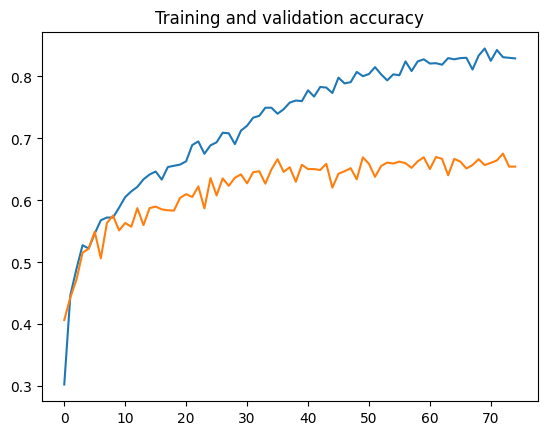

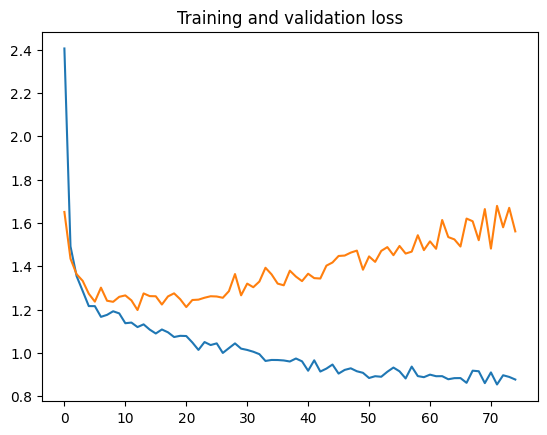

In [18]:
diagnostic_learning_curves()

In [19]:
from keras.models import load_model

model.save('flowerDetection.h5')  # créer la sauvegarde du model a HDF5 file
del model  # supprime si déja existant

# return le model compilé
model = load_model('flowerDetection.h5')
model

C:\Users\12mou\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<bound method Model.fit of <keras.src.engine.functional.Functional object at 0x0000017D8B5C7190>>

In [20]:
prediction = model.predict(val_gen)
print(f"Prediction shape: {prediction.shape}")

100/100 [==============================] - 4s 34ms/step
Prediction shape: (2000, 5)


In [21]:
model.evaluate(val_gen)

100/100 [==============================] - 4s 33ms/step - loss: 1.5610 - accuracy: 0.6545


[1.5609726905822754, 0.6545000076293945]

In [22]:
y_pred = (prediction > 0.5).astype('int32')

In [23]:
# Prediction
y_proba = model.predict(validation_generator) 
y_proba
# pd.Series(y_proba.flatten()).head()

100/100 [==============================] - 3s 33ms/step


array([[2.5468695e-01, 6.3501221e-01, 3.3839595e-02, 7.1291573e-02,
        5.1696138e-03],
       [4.5535657e-01, 5.3767693e-01, 6.2676524e-03, 3.8136021e-04,
        3.1745981e-04],
       [6.2256772e-03, 7.0092301e-03, 9.2256991e-03, 8.9528996e-01,
        8.2249485e-02],
       ...,
       [3.1319121e-04, 2.8694930e-04, 5.7450297e-06, 9.9809092e-01,
        1.3031578e-03],
       [1.0358215e-02, 9.0225745e-04, 5.3750129e-05, 9.8798114e-01,
        7.0458569e-04],
       [7.0774131e-03, 7.3539576e-04, 1.5034764e-01, 2.0082643e-02,
        8.2175702e-01]], dtype=float32)

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

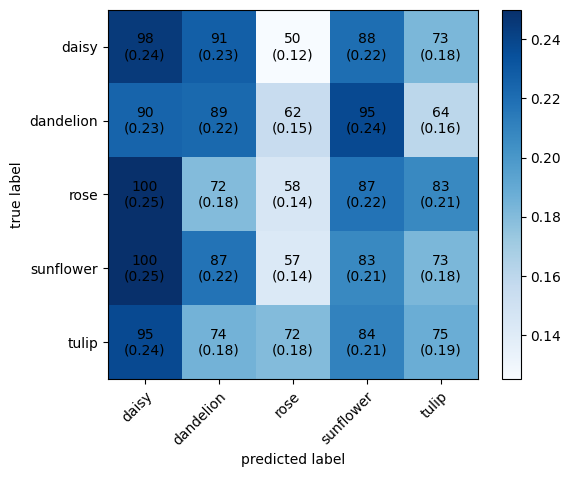

In [24]:
# Evaluation à l'aide de la matrice de confusion
import numpy as np

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(val_gen.classes, y_pred.argmax(axis=1))
conf_mat
class_names = np.array(['daisy','dandelion','rose','sunflower','tulip'])
plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                 class_names=class_names
                      )

In [25]:
from IPython.display import display
from PIL import Image
import numpy as np


In [26]:
image_path = './Fleurs/Validation/Rosa.jpg'
image = Image.open(image_path)


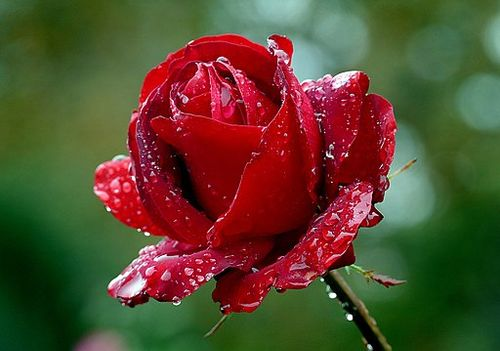

In [27]:
display(image)

In [28]:
# FleurTest = tf.keras.preprocessing.image.load_img('./Fleurs/Validation/Rosa.jpg')
# FleurTest
# FleurTest = tf.keras.preprocessing.image.img_to_array(FleurTest)
# FleurTest.shape
#l'image en pixel (avec le nombre de pixel qui et l'équivalent de l'immage)

In [29]:
# # Afficher la prédiction, cela dépend de votre modèle
# print(f"Prédiction : {prediction}")


In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Chemin de l'image à tester
image_path = './Fleurs/Validation/Rosa.jpg'

# Charger l'image et la redimensionner pour correspondre à l'entrée attendue par le modèle
img = image.load_img(image_path, target_size=(150, 150))  # Ajustez (224, 224) selon les besoins de votre modèle

# Convertir l'image en un tableau numpy
img_array = image.img_to_array(img)

# Étendre les dimensions de l'image pour qu'elle corresponde au format attendu par le modèle : (batch_size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Normaliser les données de l'image si nécessaire (dépend du modèle)
img_array = img_array / 255.0

# À ce stade, img_array est prête à être utilisée pour la prédiction
prediction = model.predict(img_array)

# Pour afficher la prédiction
print(prediction)


1/1 [==============================] - 0s 85ms/step
[[1.6099500e-02 7.0126468e-08 9.8041487e-01 1.3351445e-07 3.4853888e-03]]


In [31]:
# Supposons que class_names = ['Rose', 'Tulipe', 'Marguerite', 'Orchidée', 'Lys']
class_names = ['daisy','dandelion','rose','sunflower','tulip']

# Trouver l'indice de la plus haute probabilité
predicted_class_index = np.argmax(prediction)

# Mapper l'indice à un nom de classe
predicted_class_name = class_names[predicted_class_index]

print(f"La prédiction est : {predicted_class_name} avec une probabilité de {prediction[0][predicted_class_index]*100:.2f}%")


La prédiction est : rose avec une probabilité de 98.04%


In [32]:
image_path = './Fleurs/Validation/test.jpg'
image = Image.open(image_path)


In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Chemin de l'image à tester
image_path = './Fleurs/Validation/test.jpg'

# Charger l'image et la redimensionner pour correspondre à l'entrée attendue par le modèle
img = image.load_img(image_path, target_size=(150, 150))  # Ajustez (224, 224) selon les besoins de votre modèle

# Convertir l'image en un tableau numpy
img_array = image.img_to_array(img)

# Étendre les dimensions de l'image pour qu'elle corresponde au format attendu par le modèle : (batch_size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Normaliser les données de l'image si nécessaire (dépend du modèle)
img_array = img_array / 255.0

# À ce stade, img_array est prête à être utilisée pour la prédiction
prediction = model.predict(img_array)

# Pour afficher la prédiction
print(prediction)


1/1 [==============================] - 0s 28ms/step
[[0.03164466 0.9546012  0.00358899 0.00241476 0.00775038]]


In [34]:
class_names = ['daisy','dandelion','rose','sunflower','tulip']

# Trouver l'indice de la plus haute probabilité
predicted_class_index = np.argmax(prediction)

# Mapper l'indice à un nom de classe
predicted_class_name = class_names[predicted_class_index]

print(f"La prédiction est : {predicted_class_name} avec une probabilité de {prediction[0][predicted_class_index]*100:.2f}%")


La prédiction est : dandelion avec une probabilité de 95.46%


In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def predict_image_class(image_name, model):
#     
#     Prédit la classe d'une image en utilisant un modèle donné et affiche le nom de la classe et la probabilité.
    
#     :param image_name: Nom de l'image à prédire (en supposant un chemin fixe).
#     :param model: Modèle Keras pré-entraîné à utiliser pour la prédiction.
#     :return: None, affiche la prédiction et la probabilité.
#     

    # Définir le chemin d'accès fixe et les noms de classe
    base_path = './Fleurs/Validation/'  # Chemin d'accès fixe
    class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    
    # Construire le chemin complet de l'image
    image_path = f'{base_path}{image_name}'

    # Charger l'image et la redimensionner pour correspondre à l'entrée attendue par le modèle
    img = image.load_img(image_path, target_size=(150, 150))  # Ajustez la taille selon les besoins de votre modèle

    
    # Convertir l'image en un tableau numpy
    img_array = image.img_to_array(img)

    # Étendre les dimensions de l'image pour qu'elle corresponde au format attendu par le modèle
    img_array = np.expand_dims(img_array, axis=0)

    # Normaliser les données de l'image si nécessaire
    img_array = img_array / 255.0

    # Utiliser le modèle pour faire une prédiction sur l'image
    prediction = model.predict(img_array)

    # Trouver l'indice de la plus haute probabilité
    predicted_class_index = np.argmax(prediction)

    # Mapper l'indice à un nom de classe
    predicted_class_name = class_names[predicted_class_index]

    # Afficher la prédiction et la probabilité
    print(f"La prédiction est : {predicted_class_name} avec une probabilité de {prediction[0][predicted_class_index]*100:.2f}%")

In [36]:
predict_image_class('test.jpg', model)

1/1 [==============================] - 0s 24ms/step
La prédiction est : dandelion avec une probabilité de 95.46%


In [37]:
predict_image_class('test2.jpg', model)

1/1 [==============================] - 0s 19ms/step
La prédiction est : dandelion avec une probabilité de 99.27%


In [38]:
predict_image_class('testTP.jpg', model)

1/1 [==============================] - 0s 22ms/step
La prédiction est : daisy avec une probabilité de 76.20%


In [40]:
model

In [39]:
# # Charger le notebook pour examiner son contenu et identifier l'erreur
# import nbformat

# notebook_path = 'C:/Users/12mou/Documents/CoursDP_ML/CoursIA/AI-Fleurs/fleurs.'

# with open(notebook_path, 'r', encoding='utf-8') as nb_file:
#     notebook = nbformat.read(nb_file, as_version=4)

# # Afficher un résumé des cellules pour comprendre la structure du notebook
# # et localiser potentiellement où se trouve l'erreur
# cell_summary = [{'cell_type': cell.cell_type, 'source': cell.source[:30] + '...' if len(cell.source) > 30 else cell.source} for cell in notebook.cells]
# cell_summary
